In [ ]:
#| default_exp framestructure
#| export
import torch
from transformers import pipeline
import penman
from collections import Counter, defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import pygraphviz_layout

class FramingStructure:
    def __init__(self, base_model, roles=None):
        device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.translator = pipeline("text2text-generation", base_model, device=device, max_length=300)

    def __call__(self, sequence_to_translate, error_type=None):
        res = self.translator(sequence_to_translate)
        def try_decode(x):
            try:
                return penman.decode(x["generated_text"])
            except:
                return error_type  # None type will be filtered below.
        graphs = list(filter(lambda item: item is not None, [try_decode(x) for x in res]))
        return graphs

    def visualize(self, decoded_graphs, min_node_threshold=1, **kwargs):
        cnt = Counter()

        for gen_text in decoded_graphs:
            amr = gen_text.triples
            amr = list(filter(lambda x: x[2] is not None, amr))
            amr = list(map(lambda x: (x[0], x[1].replace(":", ""), x[2]), amr))
            def trim_distinction_end(x):
                x = x.split("_")[0]
                return x
            amr = list(map(lambda x: (trim_distinction_end(x[0]), x[1], trim_distinction_end(x[2])), amr))
            cnt.update(amr)

        G = nx.DiGraph()

        color_map = defaultdict(lambda: "k", {
            "ARG0": "y",
            "ARG1": "r",
            "ARG2": "g",
            "ARG3": "b"
        })

        for entry, num in cnt.items():
            if not G.has_node(entry[0]):
                G.add_node(entry[0], weight=0)
            if not G.has_node(entry[2]):
                G.add_node(entry[2], weight=0)
            G.nodes[entry[0]]["weight"] += num
            G.nodes[entry[2]]["weight"] += num
            G.add_edge(entry[0], entry[2], role=entry[1], weight=num, color=color_map[entry[1]])

        G_sub = nx.subgraph_view(G, filter_node=lambda n: G.nodes[n]["weight"] >= min_node_threshold)

        node_sizes = [x * 100 for x in nx.get_node_attributes(G_sub,'weight').values()]
        edge_colors = nx.get_edge_attributes(G_sub,'color').values()

        fig = plt.figure()

        pos = pygraphviz_layout(G_sub, prog="dot")
        nx.draw_networkx(G_sub, pos, node_size=node_sizes, edge_color=edge_colors)
        nx.draw_networkx_labels(G_sub, pos)
        nx.draw_networkx_edge_labels(G_sub, pos, edge_labels=nx.get_edge_attributes(G_sub, "role"))
        plt.tight_layout()
        return fig

In [ ]:
base_model = "Iseratho/model_parse_xfm_bart_base-v0_1_0"
framing_struc_model = FramingStructure(base_model)

example_list = ["In 2010, CFCs were banned internationally due to their harmful effect on the ozone layer.",
                "In 2021, doctors prevented the spread of the virus by vaccinating with Pfizer.",
                "We must fight for our freedom.",
                "The government prevents our freedom.",
                "They prevent the spread.",
                "We fight the virus.",
                "I believe that we should act now.\nThere is no time to waste.",
                ]

framing_struc_model = FramingStructure(base_model)
assert type(framing_struc_model(example_list[0])) == list
assert type(framing_struc_model(example_list)) == list
test_struct = framing_struc_model(example_list)
test_struct

[<Graph object (top=ban-01) at 140703003308432>,
 <Graph object (top=prevent-01) at 140703003297632>,
 <Graph object (top=obligate-01) at 140703003308672>,
 <Graph object (top=prevent-01) at 140703003297392>,
 <Graph object (top=prevent-01) at 140703003307616>,
 <Graph object (top=fight-01) at 140703003297584>,
 <Graph object (top=multi-sentence) at 140703003308144>]

/home/iseratho/mambaforge/envs/ds2/lib/python3.10/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: r is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


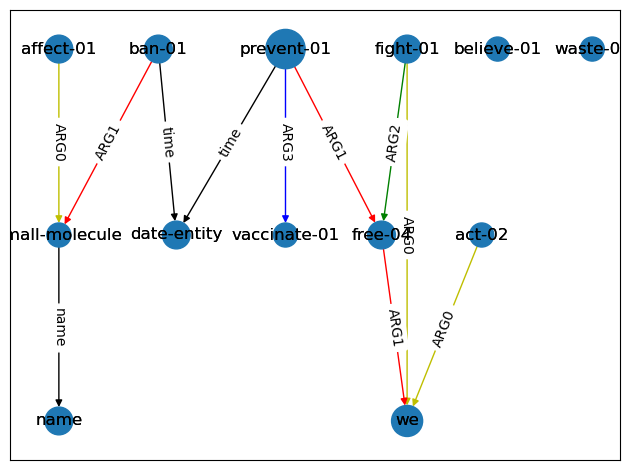

In [ ]:
framing_struc_model.visualize(test_struct, min_node_threshold=3);

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()